In [1]:
from pymodules.create_one_hot_encoded_map_from_mask import get_one_hot_map
from PIL import Image
from numpy import asarray
from os import walk
%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm
import numpy as np
from pymodules.data import adjustImage,adjustMask,trainGenerator,testGenerator,labelVisualize
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from pymodules.unet_model import unet
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import  EarlyStopping, ReduceLROnPlateau 
import tensorflow as tf

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


In [2]:
import numpy as np
import cv2
import os
from PIL import Image

# color map is different on test data
col_map = [[255,255,255],[20,20,20],[19,19,19],[0,0,0]]

X_test = []
for filepath in os.listdir('../data/test_images/ventral_samples_R0004'):
    image = Image.open('../data/test_images/ventral_samples_R0004/'+filepath)
    image = image.resize((256, 256))
    # convert image to numpy array
    data = np.asarray(image)
    data = data/255.
    X_test.append(data)
X_test = np.array(X_test)
Y_test = []
for filepath in os.listdir('../data/test_images/ventral_mask_combined_R0004'):
    image = Image.open('../data/test_images/ventral_mask_combined_R0004/'+filepath)
    image = image.resize((256, 256)) 
    Y_test.append(get_one_hot_map(np.asarray(image),col_map))
Y_test = tf.stack(Y_test)

In [3]:
batch_size = 11
epochs = 400
iterations_per_epoch = 300

data_gen_args = dict(rotation_range=0.3,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.1,
                    horizontal_flip=True,
                    fill_mode='nearest')

train_generator = trainGenerator(batch_size,'../data/train_images','ventral_samples','ventral_mask_combined',data_gen_args,image_color_mode='rgb',color_map=[[33,33,33],[20,20,20],[19,19,19],[0,0,0]],target_size = (256,256),flag_multi_class=True)
val_datagen = ImageDataGenerator()

In [4]:
model = unet(input_size = (256,256,3),output_filters=4)
model.load_weights('combined_fisrt_run.hdf5')

In [ ]:
model_checkpoint = ModelCheckpoint('combined.hdf5', monitor='val_loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor="val_loss",verbose = 1,mode='min',patience=70)
reduce_lr =  ReduceLROnPlateau(monitor = "val_loss", factor = 0.5, patience = 10,verbose = 0, mode = "auto", epsilon = 1e-04, cooldown = 0,min_lr = 1e-5)
model.fit_generator(train_generator,steps_per_epoch=iterations_per_epoch,epochs=epochs,callbacks=[model_checkpoint,early_stopping,reduce_lr],validation_data=val_datagen.flow(X_test, Y_test, batch_size=batch_size))

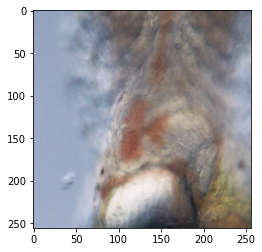

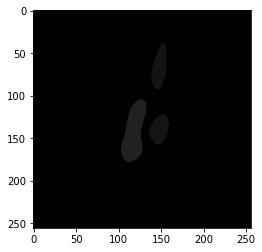

In [5]:
image_number = 2

image = Image.new('RGB', (256, 256))
maskk = model.predict(X_test[image_number].reshape(1,256,256,3))[0]
for i in range(maskk.shape[0]):
    for j in range(maskk.shape[1]):
        clazz = np.argmax(maskk[i,j])
        if clazz == 0:
            image.putpixel((j,i),(33,33,33))
        if clazz == 1:
            image.putpixel((j,i),(20,20,20))
        if clazz == 2:
            image.putpixel((j,i),(19,19,19))
        if clazz == 3:
            image.putpixel((j,i),(0,0,0))
plt.imshow(X_test[image_number])
plt.show()
plt.imshow(image)
plt.show()